In [6]:
import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import IsolationForest

In [7]:
noc_roma = pd.read_csv("../NOC_ROMA_202403110800-202403111600_clusters_la.csv")

In [8]:
noc_roma["first_occurrence"] = pd.to_datetime(noc_roma["first_occurrence"])

noc_roma = noc_roma.sort_values(by=["cluster_id", "first_occurrence"])


noc_roma["tempo_di_interarrivo"] = noc_roma.groupby("cluster_id")[
    "first_occurrence"
].diff()


noc_roma["tempo_di_interarrivo"] = noc_roma["tempo_di_interarrivo"].fillna(
    pd.Timedelta(seconds=0)
)
noc_roma["tempo_di_interarrivo"] = noc_roma["tempo_di_interarrivo"].dt.total_seconds()
noc_roma

,cluster_id,alarm_id,ne_id,NOTE SPV,domain,network,ne_type,std_probable_cause_no,geo_code,first_occurrence,last_occurrence,tempo_di_interarrivo
1,23801,"EFMTX,65eeac8489e9530001bd7c33",romaitbh/ad64/1,CORRELAZIONE OK CLUSTER 23801,tx,sdh,ad64,guasto matrice,roma,2024-03-11 08:02:27,2024-03-11 19:36:19,0.0
3,23801,"EFMTX,65eeac8389e9530001bd7c2d",romaitbh/ad64/1,CORRELAZIONE OK CLUSTER 23801,tx,sdh,ad64,guasto matrice,roma,2024-03-11 08:02:27,2024-03-11 19:36:19,0.0
4,23801,"EFMTX,65eeac8489e9530001bd7c35",romaitbh/ad64/1,CORRELAZIONE OK CLUSTER 23801,tx,sdh,ad64,guasto matrice,roma,2024-03-11 08:02:27,2024-03-11 19:36:25,0.0
6,23801,"EFMTX,65eeac8689e9530001bd7c49",romaitbh/ad64/1,CORRELAZIONE OK CLUSTER 23801,tx,sdh,ad64,guasto matrice,roma,2024-03-11 08:02:27,2024-03-11 19:36:25,0.0
9,23801,"EFMTX,65eeac8789e9530001bd7c4d",romaitbh/ad64/1,CORRELAZIONE OK CLUSTER 23801,tx,sdh,ad64,guasto matrice,roma,2024-03-11 08:02:27,2024-03-11 19:36:24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
317,28624,"EFMTX,65ef1d13cd606500014b9506",romaitgc/oadm/14,CORRELAZIONE ERRATA SU CLUSTER 28624,tx,sdh,oadm,loss of signal los,roma,2024-03-11 16:02:43,2024-03-11 16:28:06,0.0
311,28624,"EFMTX,65ef1d396423e50001f2f975",romaitdm/adm4/5,CORRELAZIONE ERRATA SU CLUSTER 28624,tx,sdh,adm4,loss of pointer lop,roma,2024-03-11 16:03:21,2024-03-11 21:22:03,38.0
312,28624,"EFMTX,65ef1d3c6423e50001f2f980",romaitdm/adm4/5,CORRELAZIONE ERRATA SU CLUSTER 28624,tx,sdh,adm4,loss of pointer lop,roma,2024-03-11 16:03:23,2024-03-11 21:21:52,2.0
313,28624,"EFMTX,65ef1d3c6423e50001f2f987",romaitdm/adm4/5,CORRELAZIONE ERRATA SU CLUSTER 28624,tx,sdh,adm4,loss of pointer lop,roma,2024-03-11 16:03:24,2024-03-11 21:21:52,1.0


## Statistics

In [9]:
noc_roma_grouped = noc_roma.groupby("cluster_id")
numero_cluster = noc_roma["cluster_id"].nunique()

cluster_corretti = []
cluster_totalmente_errati = []
cluster_parzialmente_corretti = []

for cluster_id, gruppo in noc_roma.groupby("cluster_id"):
    if gruppo["NOTE SPV"].str.contains("CORRELAZIONE OK").all():
        cluster_corretti.append(cluster_id)
    elif gruppo["NOTE SPV"].str.contains("CORRELAZIONE ERRATA").all():
        cluster_totalmente_errati.append(cluster_id)
    else:
        cluster_parzialmente_corretti.append(cluster_id)

print("Numero Cluster:", numero_cluster)
print(f"Numero di cluster corretti: {len(cluster_corretti)}")
print(f"Numero di cluster totalmente errati: {len(cluster_totalmente_errati)}")
print(f"Numero di cluster parzialmente corretti: {len(cluster_parzialmente_corretti)}")


Numero Cluster: 35
Numero di cluster corretti: 13
Numero di cluster totalmente errati: 12
Numero di cluster parzialmente corretti: 10


## Multiple values IsolationForest with Tempo di Interarrivo

Valori di contamination: 100%|██████████| 49/49 [03:23<00:00,  4.14s/it]


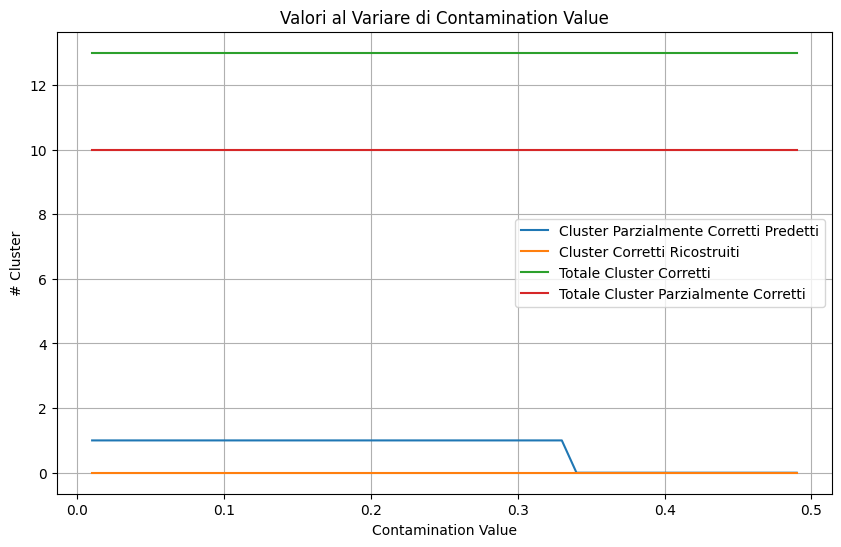

In [10]:


contamination_values = np.arange(0.01, 0.5, 0.01)
outlier_labels = []
df_list = []

results = []
reconstructed_correct_clusters_values = []
partially_correct_clusters_predicted_values = []
cluster_corretti_values = []
cluster_parzialmente_corretti_values = []

for n in tqdm(contamination_values, desc="Valori di contamination"):
    OUTLIER_LABELs = []
    df_list = []

    for cluster_id, group in noc_roma.groupby("cluster_id"):
        # Convertire i tempi in numeri
        X = (
            group[["tempo_di_interarrivo"]]
        )

        # Applicazione dell'Isolation Forest
        isolation_forest = IsolationForest(contamination=n, random_state=42)
        labels = isolation_forest.fit_predict(X)

        # Adattamento dei valori per essere coerenti con LOF (1 per normali, -1 per outlier)
        outlier_labels.extend(labels)

        # Creazione di un DataFrame temporaneo con i risultati
        temp_df = pd.DataFrame(
            {
                "cluster_id": cluster_id,
                "OUTLIER_LABEL": labels,
            }
        )

        df_list.append(temp_df)

    final_df = pd.concat(df_list, ignore_index=True)
    filtered_noc_roma = noc_roma[["NOTE SPV"]]

    merge_df = pd.merge(
        final_df, filtered_noc_roma, left_index=True, right_index=True, how="left"
    )

    merge_grouped = merge_df.groupby("cluster_id")

    predict_correct_clusters = 0
    for cluster_id, group in merge_grouped:

        if cluster_id in cluster_corretti:
            if group["OUTLIER_LABEL"].nunique() == 1:
                predict_correct_clusters += 1

    reconstructed_correct_clusters_values.append(predict_correct_clusters)
    cluster_corretti_values.append(len(cluster_corretti))

    predict_wrong_clusters = 0

    for cluster_id, group in merge_grouped:

        if cluster_id in cluster_parzialmente_corretti:
            if cluster_id in cluster_parzialmente_corretti:
                # Filtra gli allarmi con "CORRELAZIONE OK"
                allarmi_ok = group[group["NOTE SPV"].str.contains("CORRELAZIONE OK")]
                # Filtra gli allarmi con "CORRELAZIONE ERRATA"
                allarmi_errata = group[
                    group["NOTE SPV"].str.contains("CORRELAZIONE ERRATA")
                ]

                # Verifica che tutti gli allarmi OK abbiano la stessa label
                label_unica_ok = allarmi_ok["OUTLIER_LABEL"].nunique() == 1

                # Verifica che gli allarmi ERRATA abbiano una label diversa da quella degli allarmi OK
                if not allarmi_errata.empty and label_unica_ok:
                    label_ok = allarmi_ok["OUTLIER_LABEL"].iloc[0]
                    # Verifica che tutte le label ERRATA siano diverse da quella OK
                    label_diverse_errata = (
                        not allarmi_errata["OUTLIER_LABEL"].isin([label_ok]).any()
                    )

                    if label_diverse_errata:
                        predict_wrong_clusters += 1
    partially_correct_clusters_predicted_values.append(predict_wrong_clusters)
    cluster_parzialmente_corretti_values.append(len(cluster_parzialmente_corretti))


plt.figure(figsize=(10, 6))


plt.plot(contamination_values, partially_correct_clusters_predicted_values, label="Cluster Parzialmente Corretti Predetti")
plt.plot(
    contamination_values, reconstructed_correct_clusters_values, label="Cluster Corretti Ricostruiti"
)
plt.plot(contamination_values, cluster_corretti_values, label="Totale Cluster Corretti")
plt.plot(
    contamination_values,
    cluster_parzialmente_corretti_values,
    label="Totale Cluster Parzialmente Corretti",
)


plt.xlabel("Contamination Value")
plt.ylabel("# Cluster")
plt.title("Valori al Variare di Contamination Value")
plt.legend()
plt.grid(True)


plt.show()